# CS 20 : TensorFlow for Deep Learning Research
## Lecture 03 : Linear and Logistic Regression
### Logistic Regression with ce loss

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.8.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 784)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 784)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define the graph of Softmax Classifier

In [4]:
# create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype = tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype = tf.int32, shape = [None])

# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weights', shape = [784, 10], dtype = tf.float32,
                    initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name = 'bias', shape = [10], dtype = tf.float32,
                    initializer = tf.zeros_initializer())
# construct model
score = tf.matmul(X, w) + b

# use the cross entropy as loss function
ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = Y, logits = score))
ce_loss_summ = tf.summary.scalar(name = 'ce_loss', tensor = ce_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(ce_loss)

### Training

In [5]:
epochs = 30
batch_size = 64
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

859


In [6]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]), size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]), size = batch_size, replace = False)
        
        batch_xs = x_tr[batch_indices] 
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, ce_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        tr_loss_summ = sess.run(ce_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [ce_loss, ce_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    if epoch % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 1.04, val_loss : 1.04
epoch :   5, tr_loss : 0.40, val_loss : 0.40
epoch :  10, tr_loss : 0.36, val_loss : 0.36
epoch :  15, tr_loss : 0.34, val_loss : 0.34
epoch :  20, tr_loss : 0.32, val_loss : 0.32
epoch :  25, tr_loss : 0.32, val_loss : 0.31


### Visualization

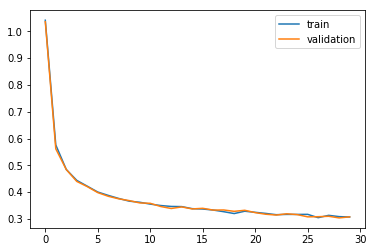

In [8]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [9]:
yhat = np.argmax(sess.run(score, feed_dict = {X : x_tst}), axis = 1)
print('acc : {:.2%}'.format(np.mean(yhat == y_tst)))

acc : 91.78%
